# SENTIMENT ANALYSIS WITH BERT 

In this post we will take a pretrained model and we will create a classifiers on top of it.

## Install dependencies ##

In [ ]:
!pip install transformers tokenizers pytorch-lightning torch

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [6]:
assert(torch.__version__ == '1.4.0')

### Discuta despre cum incarci modelele ###

In [8]:
tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")

INFO:transformers.tokenization_utils:Model name 'dumitrescustefan/bert-base-romanian-cased-v1' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1). Assuming 'dumitrescustefan/bert-base-romanian-cased-v1' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file dumitrescustefan/bert-base-romanian-cased-v1/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file dumitrescustefan/bert-base-romanian-cased-v1

In [11]:
sentence = "Acesta este un test."
enc_sentence = tokenizer.encode(sentence, add_special_tokens=True)
input_ids = torch.tensor(enc_sentence).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

In [10]:
outputs[0].shape, outputs[1].shape

(torch.Size([1, 7, 768]), torch.Size([1, 768]))

In [19]:
# Load Data
train_df = pd.read_csv("./ro/train.csv")
train_df.label = train_df.label.astype('category')

test_df = pd.read_csv("./ro/test.csv")

In [20]:
train_df.describe()

,index
count,17941.000000
mean,4736.087843
std,2982.913642
min,0.000000
25%,2242.000000
50%,4485.000000
75%,6727.000000
max,11093.000000


Text(0.5, 1.0, 'Training Label Distribution')

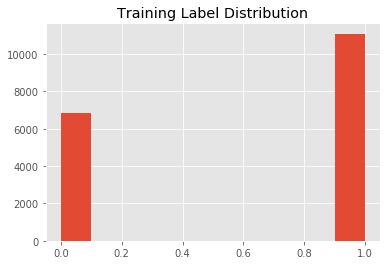

In [23]:
train_df.label.hist()
plt.title("Training Label Distribution")

In [24]:
pd.options.display.max_colwidth = 500
train_df.head()

,index,text,label
0,0,"acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile din 11 septembrie. acest film a fost construit in mod expert si prezinta acest dezastru ca fiind mai mult decat un atac asupra pamantului american. urmarile acestui dezastru sunt previzionate din multe tari si perspective diferite. cred ca acest film ar trebui sa fie mai bine distribuit pentru acest punct. de asemenea, el ajuta in procesul de vindecare sa vada in cele din urma a...",1
1,1,"tine mancarea rece. ce altceva ii mai trebuie?\nam frigiderul de vreun an, utilizare continua.\nzgomotul e decent spre scazut daca esti in aceeasi incapere cu el. nu il auzi din dormitory cu usile inchise.\ne un frigider ce sa zici despre el?\no sa tina mancarea rece, la temperaturile indicate. recomand sa spalati bine dispenserul de lichide dupa utilizare ca sa nu se contamineze apa. da asta e de bun simt: d",1
2,2,excelent\nrecomand!,1
3,3,"ca un rocker imbatranit, acest film mentioneaza heep and quo - cele doua trupe preferate ale mele vreodata - dar cu o distributie incredibila (toata lumea) - si povestea fantastica - imi place doar aceasta piesa de geniu creativ. nu-l pot recomanda mai mult - si mick jones a adaugat atat de mult (leaderul si scriitorul principal alaturi de cel mai mare cantaret rock - lou gramm) - am vazut aceasta mare lucrare mai mult de 10 ori - bill nighy - ce voce - si jimmy nail - talentul risipeste de ...",1
4,4,"ei bine, a facut o groaza veche si foarte intunecata in casa. setare buna, care include personajul lui poe, el insusi, facand referire la poveste intr-un pub din londra. desi de aici este destul de mult un tip care a luat indrazneala sa viziteze casa intr-o noapte speciala care ruleaza din camera in camera, fie cauta sau evita oameni, este inca cea mai placuta. in plus, avem incantatoarea si enigmatica barbara steele. exista un dialog din lemn si niste biti si boboci inexplicabili, dar este ...",1


KeyboardInterrupt: 

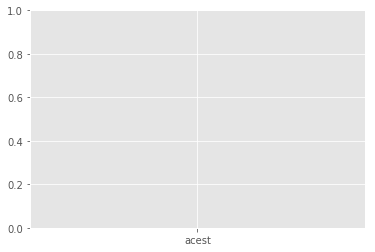

In [27]:
plt.figure(1)
train_df_context_len = train_df.text.str.split(" ")
train_df_context_len.hist(bins=40)
plt.title("Training Context Length Statistics")
print(train_df_context_len.describe())